#Creating and Running an Agent with Azure AI Projects

In this tutorial, we will walk through the steps to create and interact with a custom AI agent using Azure AI Projects. By leveraging Azure’s agent and tool functionality, we can enhance the capabilities of language models, enabling them to perform specific tasks and respond with real-time data or complex logic. The workflow includes creating an agent, configuring it with tools like a code interpreter, interacting with the agent, and handling messages, responses, and file outputs.

The key steps involve:

1. Setting up the environment and credentials
2. Creating an AI agent with CodeInterpreterTool
3. Managing conversation threads and messages
4. Processing agent responses, including saving files and handling errors
5. Deleting the agent once done



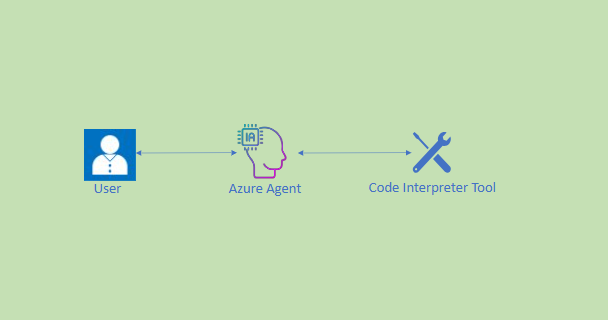

In [1]:
#!pip install azure-ai-projects==1.0.0b8 azure-identity==1.21.0 load_dotenv

In [1]:
# Set up your environment variables for the Azure OpenAI endpoint and API key.

import os
from dotenv import load_dotenv
load_dotenv('agents_2.env')
CLIENT_ID = os.getenv("CLIENT_ID")
CLIENT_SECRET = os.getenv("CLIENT_SECRET")
TENANT_ID = os.getenv("TENANT_ID")
PROJECT_CONNECTION_STRING = os.getenv("PROJECT_ENDPOINT")
print(PROJECT_CONNECTION_STRING)



eastus.api.azureml.ms;3affd6bf-159d-49f9-b568-79234a2bba60;rg-ai-hub;waqkh-6568


In [3]:
# Set Up Azure Resources: Create and configure your Azure AI Hub, AI project, and related resources (e.g., AI Services, Storage).

In [ ]:

# Authentication / Uploading File / Create Agent / Create Thread

import os
from azure.ai.projects import AIProjectClient
from azure.ai.agents.models import CodeInterpreterTool, FilePurpose
from azure.identity import ClientSecretCredential
from pathlib import Path

# Authenticate and initialize client
credential = ClientSecretCredential(
    tenant_id=os.getenv("TENANT_ID"),
    client_id=os.getenv("CLIENT_ID"),
    client_secret=os.getenv("CLIENT_SECRET")
)
project_client = AIProjectClient(
        endpoint=os.environ["PROJECT_ENDPOINT"] ,
        credential=credential,  # Use Azure Default Credential for authentication
    )

# Upload file
file = project_client.agents.files.upload_and_poll(
    file_path="../data/sales_data.csv", 
    purpose=FilePurpose.AGENTS
)
print(f"Uploaded file, file ID: {file.id}")

# Create agent and interact
with project_client:
    agent = project_client.agents.create_agent(
        model=os.environ["MODEL_DEPLOYMENT_NAME"],  # Model deployment name
        name="my-agent-for-code-interpreter",
        instructions="You are a helpful agent that perform Data Analysis and Visualiation",
        tools=CodeInterpreterTool(file_ids=[file.id]).definitions,
        tool_resources=CodeInterpreterTool(file_ids=[file.id]).resources
    )
    print(f"Created agent, agent ID: {agent.id}")

    thread = project_client.agents.threads.create()
    print(f"Created thread, thread ID: {thread.id}")

    while True:
        if (user_message := input("User: ")).lower() == "end":
            print("Ending conversation.")
            break

        message = project_client.agents.messages.create(
            thread_id=thread.id,
            role="user",  # Role of the message sender
            content=user_message,  # Message content
        )

        # Process the agent's run
        run = project_client.agents.runs.create_and_process(
            thread_id=thread.id,
            agent_id=agent.id,
        )
        print(f"Run finished with status: {run.status}")

        if run.status == "failed":
            print(f"Run failed: {run.last_error}")

        latest_message = next(msg for msg in project_client.agents.messages.list(thread_id=thread.id) if msg.role == "assistant")
        if agent_response := next((content.text.value for content in latest_message.content if content.type == "text"), None):
            print(f"Agent: {agent_response}")

        for content in latest_message.content:
            if content.type == "image_file":
                file_name = f"{content.image_file.file_id}_image_file.png"
                file_id = content.image_file.file_id
                project_client.agents.files.save(file_id=file_id, file_name=file_name)
                print(f"Saved image file to: {Path.cwd() / file_name}")

    project_client.agents.delete_agent(agent.id)
    print("Deleted agent")


AttributeError: type object 'AIProjectClient' has no attribute 'from_connection_string'